This notebook explores the nodule dataframe created by the script `preprocessing/create_nodule_df.py`

In [19]:
from utils.common_imports import *

df = pd.read_csv(f"out/nodule_df_all.csv")
display(df.shape)
df.head(3)

(2625, 13)

,Unnamed: 0,pid,nodule_idx,consensus_centroid,bbox_dim,consensus_bbox,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,malignancy_consensus,cancer_label
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,"(366, 315, 89)",64,"((334, 398), (283, 347), (57, 121))",32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)",5,Malignant
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,"(361, 345, 185)",64,"((329, 393), (313, 377), (153, 217))",30.781671,7244.667508,"(88, 89)",2,"(5, 4)",5,Malignant
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,"(346, 368, 66)",64,"((314, 378), (336, 400), (34, 98))",31.664468,4731.410934,"(102,)",1,"(2,)",2,Benign


# EDA on Raw Attributes

## Malignancy distribution

In [20]:
print("Consensus cancer rate in nodules:")
df["cancer_label"].value_counts()

Consensus cancer rate in nodules:


cancer_label
Ambiguous    1240
Benign        815
Malignant     570
Name: count, dtype: int64

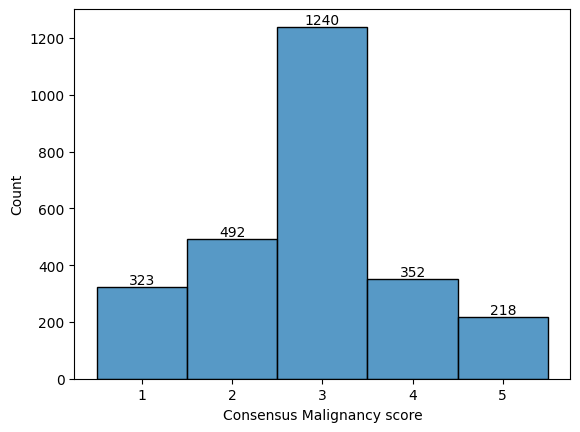

In [21]:
sns.histplot(data=df, x="malignancy_consensus", discrete=True)
vals = df["malignancy_consensus"].value_counts().sort_index().values
for i in range(0, 5):
    plt.text(i+1, vals[i], vals[i], ha="center", va="bottom")
plt.xlabel("Consensus Malignancy score")
plt.show()

## Nodule size - Diameter and Volume

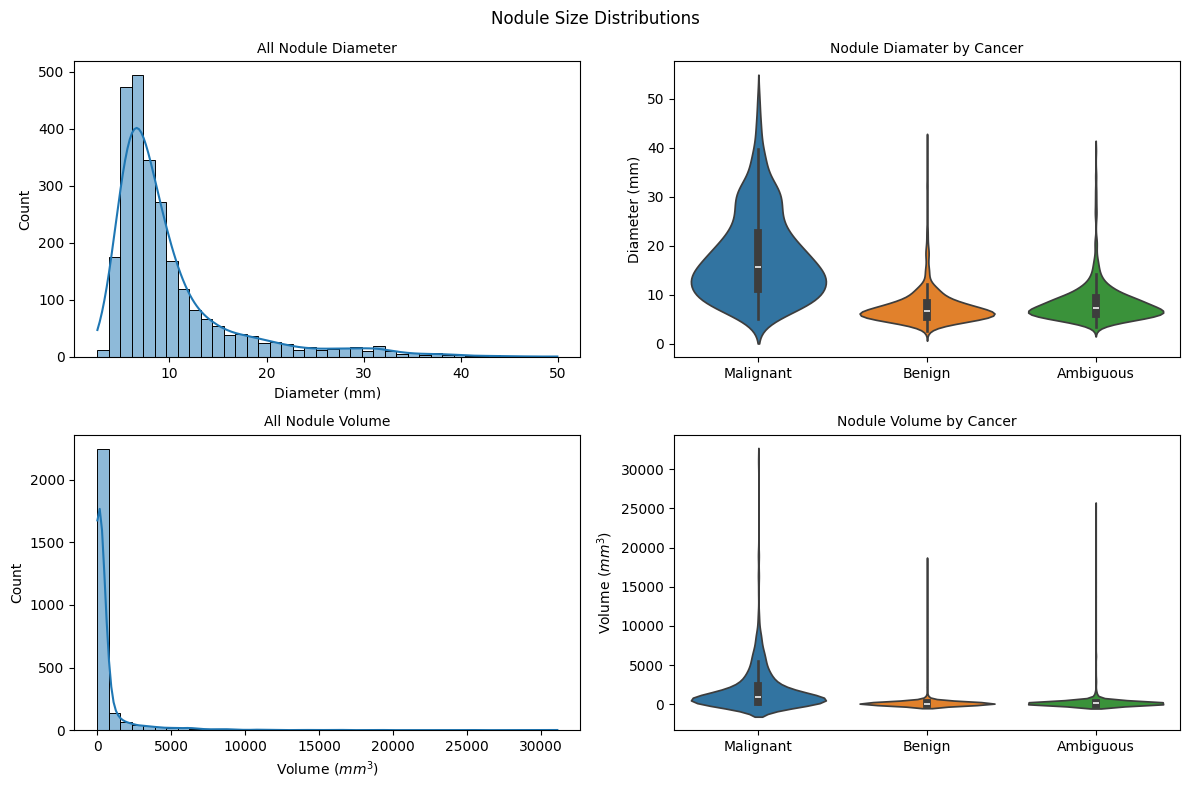

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(data=df, x="ann_mean_diameter", bins=40, kde=True, ax=axs[0,0])
axs[0, 0].set_title("All Nodule Diameter", fontsize=10)
axs[0, 0].set_xlabel("Diameter (mm)")

sns.violinplot(data=df, x="cancer_label", y="ann_mean_diameter", hue="cancer_label", ax=axs[0,1])
axs[0, 1].set_title("Nodule Diamater by Cancer", fontsize=10)
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("Diameter (mm)")

sns.histplot(data=df, x="ann_mean_volume", bins=40, kde=True, ax=axs[1,0])
axs[1, 0].set_title("All Nodule Volume", fontsize=10)
axs[1, 0].set_xlabel("Volume ($mm^3$)")

sns.violinplot(data=df, x="cancer_label", y="ann_mean_volume", hue="cancer_label", ax=axs[1,1])
axs[1, 1].set_title("Nodule Volume by Cancer", fontsize=10)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("Volume ($mm^3$)")

plt.suptitle("Nodule Size Distributions", fontsize=12)
plt.tight_layout()
plt.show()

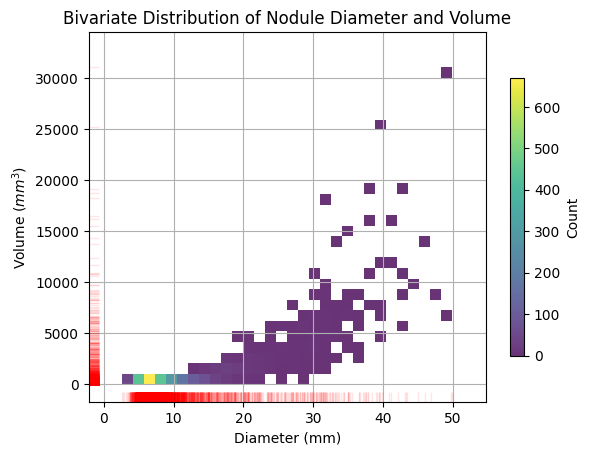

ann_mean_diameter
False    2622
True        3
Name: count, dtype: int64

In [23]:
sns.histplot(data=df, x="ann_mean_diameter", y="ann_mean_volume", bins=30, cbar=True, cbar_kws=dict(shrink=0.75, label="Count"), cmap="viridis", alpha=0.8)
sns.rugplot(data=df, x="ann_mean_diameter", y="ann_mean_volume", color="red", alpha=0.1)
plt.title("Bivariate Distribution of Nodule Diameter and Volume")
plt.ylabel("Volume $(mm^3)$")
plt.xlabel("Diameter (mm)")
plt.ylim(bottom=-1700)
plt.grid()
plt.show()

# also see the number of nodules with diameter <= 3mm
display((df["ann_mean_diameter"] <= 3).value_counts())

There are only 3 nodules smaller than 3 mm in diameter?

(0.999, 4.0]    2612
(4.0, 8.0]        13
Name: count, dtype: int64

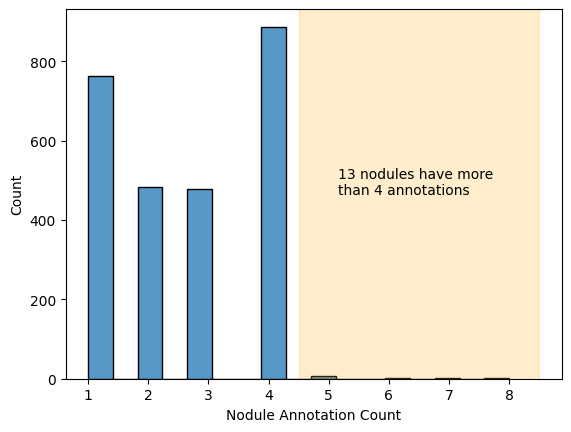

In [24]:
# Nodule Annotation Count
display(df["nodule_annotation_count"].value_counts(bins=[1,4, 8]))
sns.histplot(data=df, x="nodule_annotation_count")
plt.xlabel("Nodule Annotation Count")
plt.text(0.55, 0.5, f"{sum(df['nodule_annotation_count'] > 4)} nodules have more\nthan 4 annotations", transform=plt.gca().transAxes)
# color the right side of the plot
plt.axvspan(5-.5, 8+.5, color='orange', alpha=0.2)
plt.show()


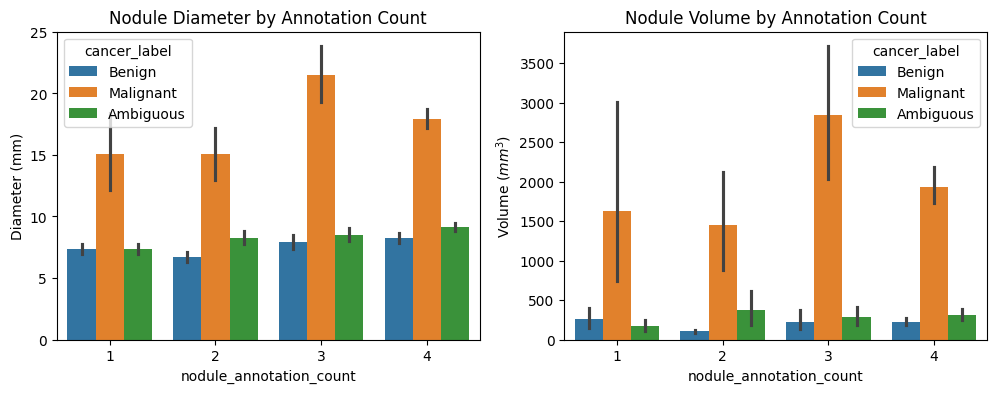

In [25]:
# stratify on nodule annotation count, and plot diameter
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_diameter", hue="cancer_label", ax=axs[0])
axs[0].set_title("Nodule Diameter by Annotation Count")
axs[0].set_ylabel("Diameter (mm)")
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_volume", hue="cancer_label", ax=axs[1])
axs[1].set_title("Nodule Volume by Annotation Count")
axs[1].set_ylabel("Volume $(mm^3)$")
plt.show()

In [26]:
# check if the nodules with multiple annotations belongs to the patient with mutliple scans:
pids = df.query("nodule_annotation_count > 4")["pid"].tolist()

for p in pids:
    print(len(pl.query(pl.Scan).filter(pl.Scan.patient_id == p).all()))

1
1
1
1
1
1
1
1
1
1
1
1
1


# Nodule per patient

In [39]:
df.head()

,Unnamed: 0,pid,nodule_idx,consensus_centroid,bbox_dim,consensus_bbox,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,malignancy_consensus,cancer_label
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,"(366, 315, 89)",64,"((334, 398), (283, 347), (57, 121))",32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)",5,Malignant
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,"(361, 345, 185)",64,"((329, 393), (313, 377), (153, 217))",30.781671,7244.667508,"(88, 89)",2,"(5, 4)",5,Malignant
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,"(346, 368, 66)",64,"((314, 378), (336, 400), (34, 98))",31.664468,4731.410934,"(102,)",1,"(2,)",2,Benign
3,1_LIDC-IDRI-0003,LIDC-IDRI-0003,1,"(350, 366, 75)",64,"((318, 382), (334, 398), (43, 107))",31.001964,6519.463698,"(90, 93, 98, 99)",4,"(5, 5, 3, 4)",5,Malignant
4,2_LIDC-IDRI-0003,LIDC-IDRI-0003,2,"(197, 307, 82)",64,"((165, 229), (275, 339), (50, 114))",13.309155,472.089669,"(91, 95, 97, 100)",4,"(4, 4, 3, 2)",4,Malignant


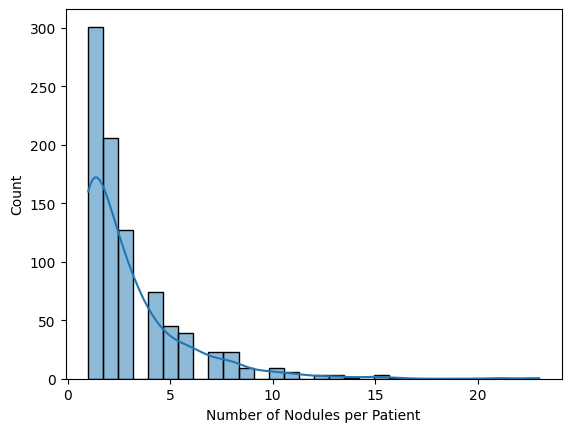

In [40]:
# This is useful for when we need to make the datasplits and for cross validation
sns.histplot(df.groupby("pid").size(), bins=30, kde=True)
plt.xlabel("Number of Nodules per Patient")
plt.show()

# Filtering

In [28]:
fil_df = df.query("cancer_label != 'Ambiguous'")
fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})
fil_df

# display(fil_df["cancer_label"].value_counts(normalize=True))

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_55061/165000911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})


,Unnamed: 0,pid,nodule_idx,consensus_centroid,bbox_dim,consensus_bbox,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,malignancy_consensus,cancer_label
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,"(366, 315, 89)",64,"((334, 398), (283, 347), (57, 121))",32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)",5,1
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,"(361, 345, 185)",64,"((329, 393), (313, 377), (153, 217))",30.781671,7244.667508,"(88, 89)",2,"(5, 4)",5,1
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,"(346, 368, 66)",64,"((314, 378), (336, 400), (34, 98))",31.664468,4731.410934,"(102,)",1,"(2,)",2,0
3,1_LIDC-IDRI-0003,LIDC-IDRI-0003,1,"(350, 366, 75)",64,"((318, 382), (334, 398), (43, 107))",31.001964,6519.463698,"(90, 93, 98, 99)",4,"(5, 5, 3, 4)",5,1
4,2_LIDC-IDRI-0003,LIDC-IDRI-0003,2,"(197, 307, 82)",64,"((165, 229), (275, 339), (50, 114))",13.309155,472.089669,"(91, 95, 97, 100)",4,"(4, 4, 3, 2)",4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,0_LIDC-IDRI-1011,LIDC-IDRI-1011,0,"(297, 406, 56)",64,"((265, 329), (374, 438), (24, 88))",28.675805,6039.291382,"(4484, 4486, 4489, 4492)",4,"(4, 3, 4, 3)",4,1
2621,1_LIDC-IDRI-1011,LIDC-IDRI-1011,1,"(253, 381, 72)",64,"((221, 285), (349, 413), (40, 104))",32.859210,4170.822144,"(4483, 4487, 4490, 4493)",4,"(3, 5, 5, 5)",5,1
2622,2_LIDC-IDRI-1011,LIDC-IDRI-1011,2,"(166, 213, 85)",64,"((134, 198), (181, 245), (53, 117))",22.721655,2185.342789,"(4482, 4485, 4488, 4494)",4,"(2, 5, 5, 5)",5,1
2623,3_LIDC-IDRI-1011,LIDC-IDRI-1011,3,"(231, 205, 108)",64,"((199, 263), (173, 237), (76, 140))",6.544805,92.315674,"(4491,)",1,"(2,)",2,0
